<a href="https://colab.research.google.com/github/Dhakal33/Univariate-Time-Series-Forecasting/blob/main/Univariate_Time_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Comparing the performance of a deep LSTM neural network and SARIMA model to forecast daily PM 2.5 concentration**

*Please refer to this publication to learn more about this study.*

Dhakal, S., Gautam, Y., & Bhattarai, A. (2021). Exploring a deep LSTM neural network to forecast daily PM 2.5 concentration using meteorological parameters in Kathmandu Valley, Nepal. Air Quality, Atmosphere & Health, 14, 83-96. DOI: https://doi.org/10.1007/s11869-020-00915-6

In [ ]:
# Import air quality dataset
from google.colab import files
uploaded = files.upload()


Saving PM25_withDate.xlsx to PM25_withDate (1).xlsx


In [ ]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from datetime import datetime

In [111]:
# Read excel file as pandas dataframe
df = pd.read_excel("PM25_withDate (1).xlsx")
df.head()

,Date,PM25,Tmax,Tmin,Humidity,Dew,Pressure,WindSpeed
0,2019-01-13,183,19.0,1.0,70.0,2.5,1023.0,1.5
1,2019-01-14,181,18.0,2.5,70.0,2.0,1023.0,1.5
2,2019-01-15,174,17.5,2.0,70.0,2.5,1023.0,1.5
3,2019-01-16,163,16.0,2.0,66.0,2.5,1022.0,1.8
4,2019-01-17,163,15.0,1.5,72.5,2.0,1022.5,1.5


In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 488 entries, 0 to 487
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       488 non-null    datetime64[ns]
 1   PM25       488 non-null    int64         
 2   Tmax       488 non-null    float64       
 3   Tmin       488 non-null    float64       
 4   Humidity   488 non-null    float64       
 5   Dew        488 non-null    float64       
 6   Pressure   488 non-null    float64       
 7   WindSpeed  488 non-null    float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 30.6 KB


In [113]:
# Feature Engineering - To extract the Months and Year from the 'Date' column
df['Year'] = df['Date'].apply(lambda date:date.year)
df['Month'] = df['Date'].apply(lambda date:date.month)
df.head()

,Date,PM25,Tmax,Tmin,Humidity,Dew,Pressure,WindSpeed,Year,Month
0,2019-01-13,183,19.0,1.0,70.0,2.5,1023.0,1.5,2019,1
1,2019-01-14,181,18.0,2.5,70.0,2.0,1023.0,1.5,2019,1
2,2019-01-15,174,17.5,2.0,70.0,2.5,1023.0,1.5,2019,1
3,2019-01-16,163,16.0,2.0,66.0,2.5,1022.0,1.8,2019,1
4,2019-01-17,163,15.0,1.5,72.5,2.0,1022.5,1.5,2019,1


In [114]:
features_considered=['PM25','Year','Month'] #['Dew','Pressure','Tmax','Tmin']
dataset = df[features_considered]
dataset.index = df['Date']
dataset.head()

,PM25,Year,Month
Date,,,
2019-01-13,183,2019,1
2019-01-14,181,2019,1
2019-01-15,174,2019,1
2019-01-16,163,2019,1
2019-01-17,163,2019,1


In [115]:
# Mapping to rename the entries of the 'Month' column
num_to_name = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',
                                  6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
dataset['Month'] = dataset['Month'].map(num_to_name)
dataset.head()

<ipython-input-115-6a37d8744ce1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Month'] = dataset['Month'].map(num_to_name)


,PM25,Year,Month
Date,,,
2019-01-13,183,2019,Jan
2019-01-14,181,2019,Jan
2019-01-15,174,2019,Jan
2019-01-16,163,2019,Jan
2019-01-17,163,2019,Jan


Text(0.5, 1.0, 'PM2.5 - Kernel Density Estimation')

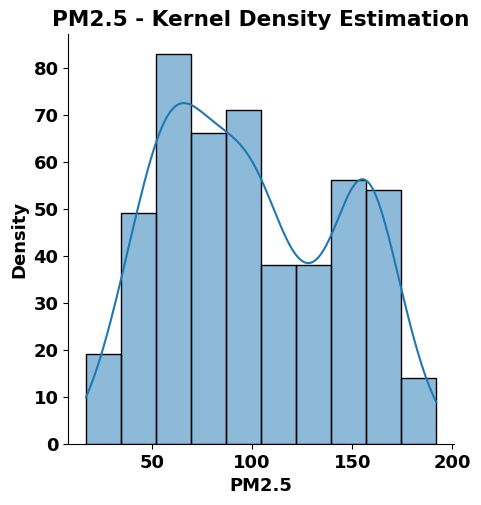

In [116]:
sns.displot(dataset['PM25'],kde=True)
plt.xlabel('PM2.5',fontweight='bold')
plt.ylabel('Density',fontweight='bold')
plt.title('PM2.5 - Kernel Density Estimation',fontweight='bold')

<ipython-input-117-f88905045c3e>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Month',data=dataset,y='PM25',palette='viridis',ax=axs[0])
<ipython-input-117-f88905045c3e>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axs[1],x='Year',data=dataset,y='PM25',palette='viridis')


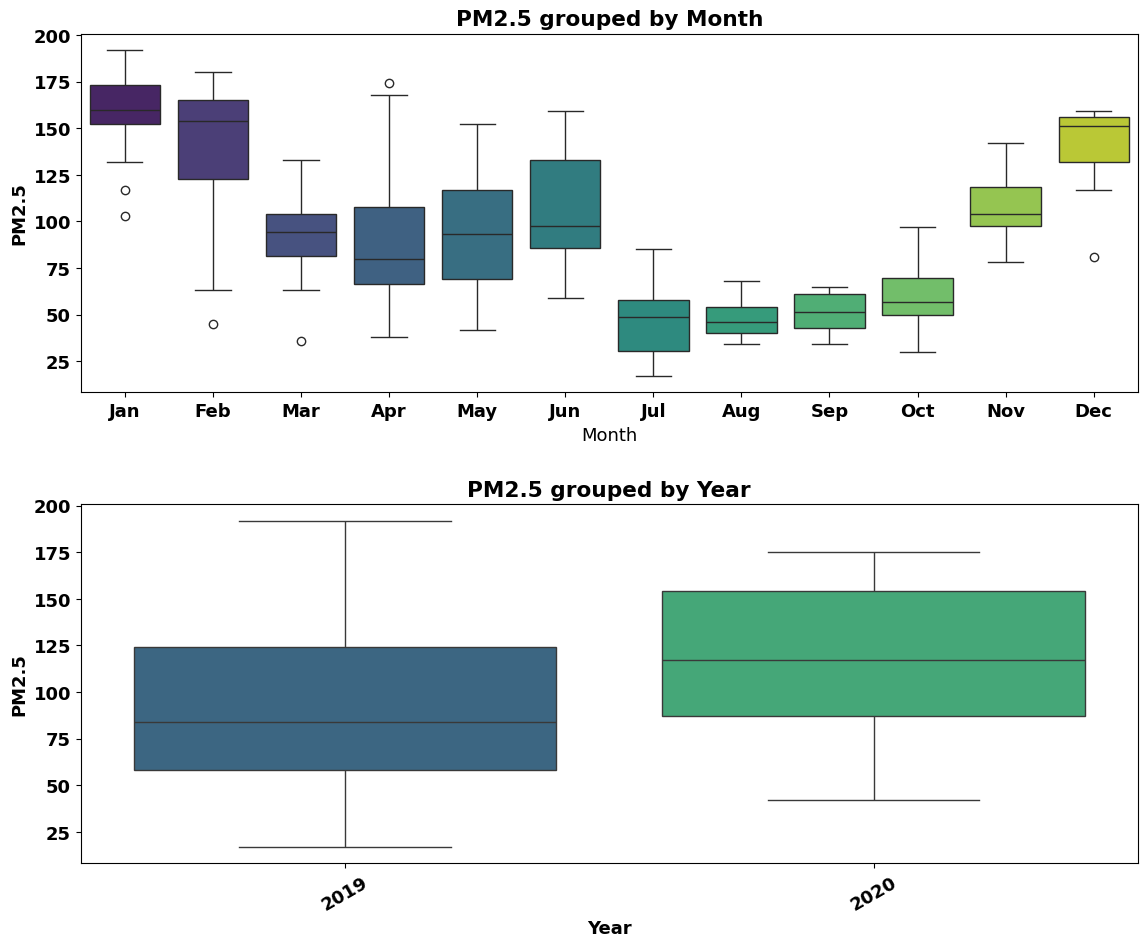

In [117]:
# Boxplots of PM2.5 grouped by Month and Year.
fig,axs=plt.subplots(2,1,figsize=(12,10))
plt.rcParams["font.weight"] = "bold"
plt.rcParams['font.size']=13

sns.boxplot(x='Month',data=dataset,y='PM25',palette='viridis',ax=axs[0])
axs[0].set_ylabel('PM2.5',fontweight='bold')
axs[0].set_title('PM2.5 grouped by Month',fontweight='bold')

sns.boxplot(ax=axs[1],x='Year',data=dataset,y='PM25',palette='viridis')
axs[1].set_xlabel('Year',fontweight='bold')
axs[1].set_ylabel('PM2.5',fontweight='bold')
axs[1].set_title('PM2.5 grouped by Year',fontweight='bold')

plt.setp(axs[1].get_xticklabels(), rotation=30)

for ax in axs.flat:
    ax.figure.tight_layout(pad=2)

In [118]:
# Dropping the 'Year', 'Month' columns
data = dataset.drop(['Year','Month'],axis=1)
data.head()

,PM25
Date,
2019-01-13,183
2019-01-14,181
2019-01-15,174
2019-01-16,163
2019-01-17,163


Text(0.5, 1.0, 'PM2.5 Time Series')

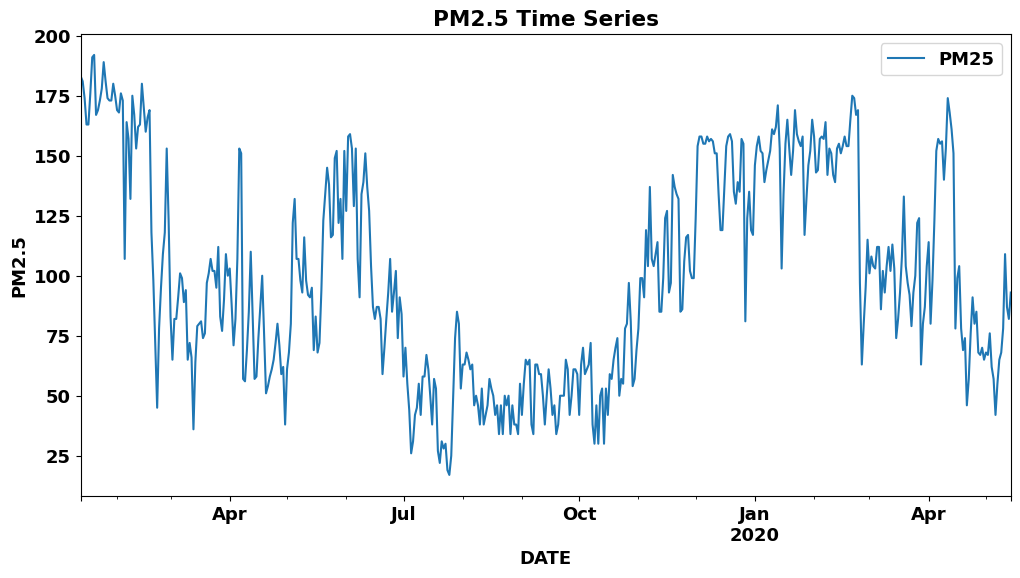

In [122]:
# Time Series Plot
data.plot(figsize=(12,6))
plt.xlabel('DATE',fontweight='bold')
plt.ylabel('PM2.5',fontweight='bold');
plt.title('PM2.5 Time Series',fontweight='bold')

### **Data Preparation**

In [154]:
split_time = 473

dataset = data.values

series = np.array(dataset)
time = np.array(data.index)
series.shape

(488, 1)

In [155]:
print(series.shape)
print(time.shape)

(488, 1)
(488,)


In [156]:
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

# **Long Short Term Memory (LSTM)**

In [125]:
window_size = 15
batch_size = 20
shuffle_buffer_size = 20

In [126]:
# Importing the necessary libraries to create/construct the deep neural network model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras import initializers
import tensorflow as tf

In [128]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    #series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    #ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [129]:
dataset = tf.data.Dataset.from_tensor_slices(series)
dataset = dataset.window(15, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
#dataset = dataset.shuffle(buffer_size=20)
dataset = dataset.batch(20).prefetch(1)
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.int64, name=None), TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))>

In [130]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(batch_size).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [191]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 15
batch_size = 20
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=15, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(30, return_sequences=True),
  tf.keras.layers.LSTM(15, return_sequences=True),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 180)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=50, callbacks=[lr_schedule])

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.int64, name=None), TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))>
(473, 1)


Epoch 1/50
23/23 [==============================] - 5s 17ms/step - loss: 54.4266 - mae: 54.9248 - lr: 1.0000e-08
Epoch 2/50
23/23 [==============================] - 0s 16ms/step - loss: 53.1966 - mae: 53.6947 - lr: 1.1220e-08
Epoch 3/50
23/23 [==============================] - 0s 16ms/step - loss: 51.4887 - mae: 51.9866 - lr: 1.2589e-08
Epoch 4/50
23/23 [==============================] - 0s 16ms/step - loss: 49.4371 - mae: 49.9353 - lr: 1.4125e-08
Epoch 5/50
23/23 [==============================] - 0s 15ms/step - loss: 47.2460 - mae: 47.7434 - lr: 1.5849e-08
Epoch 6/50
23/23 [==============================] - 0s 16ms/step - loss: 45.4334 - mae: 45.9315 - lr: 1.7783e-08
Epoch 7/50
23/23 [==============================] - 0s 16ms/step - loss: 44.1972 - mae: 44.6954 - lr: 1.9953e-08
Epoch 8/50
23/23 [==============================] - 0s 16ms/step - loss: 43.3840 - mae: 43.8823 - lr: 2.2387e-08
Epoch 9/50
23/23 [==============================] - 0s 17ms/step - loss: 42.8351 - mae: 43.3332 

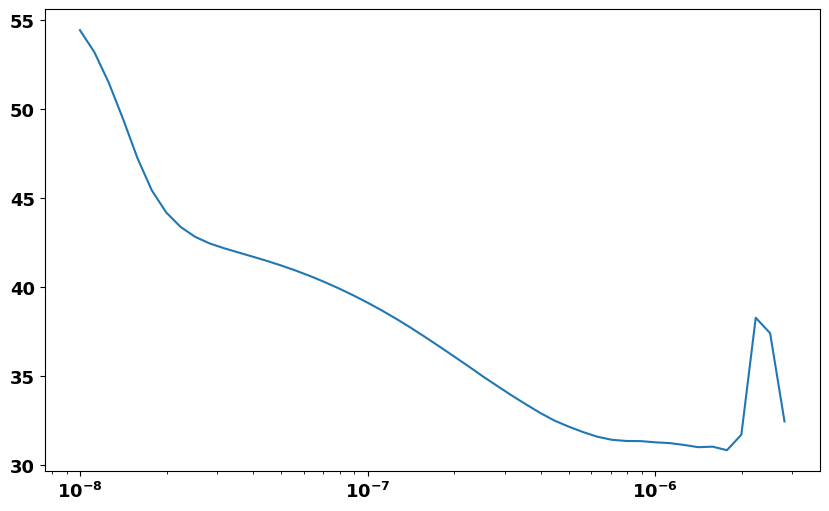

In [192]:
plt.semilogx(history.history["lr"], history.history["loss"])

In [193]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 15)          90        
                                                                 
 lstm (LSTM)                 (None, None, 30)          5520      
                                                                 
 lstm_1 (LSTM)               (None, None, 15)          2760      
                                                                 
 dense (Dense)               (None, None, 10)          160       
                                                                 
 dense_1 (Dense)             (None, None, 1)           11        
                                                                 
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
Total params: 8541 (33.36 KB)
Trainable params: 8541 (33

24/24 [==============================] - 1s 6ms/step
(474, 15, 1)


Text(0, 0.5, 'PM 2.5')

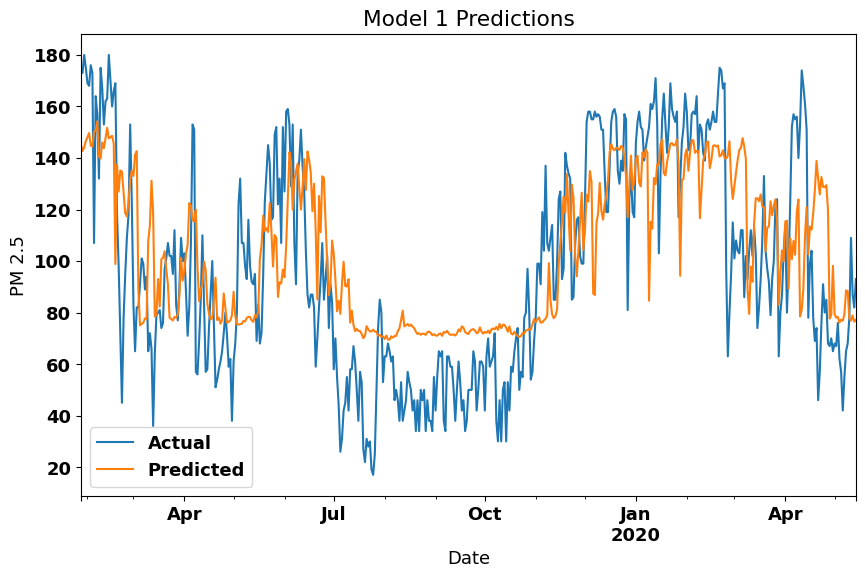

In [194]:
rnn_forecast = model_forecast(model, series, window_size)
print(rnn_forecast.shape)
rnn_forecast = rnn_forecast[:, -1, 0].reshape(474,1)
nseries=np.concatenate((series[15:],rnn_forecast[:-1]),axis=1)
nseries.shape
df = pd.DataFrame(data=nseries, index=time[15:], columns=[ "Actual","Predicted"])
ax=df.plot(figsize=(10,6), title='Model 1 Predictions')
ax.set_xlabel("Date")
ax.set_ylabel("PM 2.5")

24/24 [==============================] - 0s 6ms/step
(15,)
17.166851


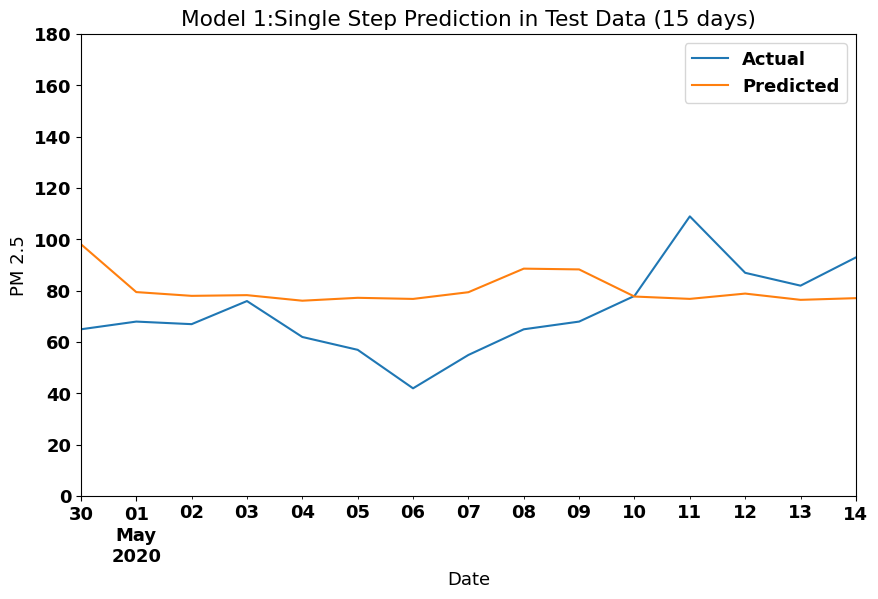

In [195]:
rnn_forecast = model_forecast(model, series, window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
print(rnn_forecast.shape)
nseries=np.concatenate((x_valid,rnn_forecast.reshape(15,1)),axis=1)
nseries.shape
df = pd.DataFrame(data=nseries, index=time_valid, columns=[ "Actual","Predicted"])
ax=df.plot(figsize=(10,6),title='Model 1:Single Step Prediction in Test Data (15 days)')
ax.set_xlabel("Date")
ax.set_ylabel("PM 2.5")
ax.set_ylim([0,180])
print(tf.keras.metrics.mean_absolute_error(x_valid[:,0], rnn_forecast).numpy())
# print(root_mean_squared_error(x_valid[:,0], rnn_forecast))

In [196]:
tf.keras.metrics.mean_absolute_error(x_valid[:,0], rnn_forecast).numpy()

17.166851

# **Seasonal Auto Regressive Moving Average (SARIMA)**

In [150]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [151]:
! pip install pmdarima

In [160]:
print('Result of Dickey-Fuller Test')
dftest = adfuller(data['PM25'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
  dfoutput['critical value (%s)'%key]=value

print(dfoutput)

Result of Dickey-Fuller Test
Test Statistic                  -3.053930
p-value                          0.030156
#Lags Used                       6.000000
Number of Observations Used    481.000000
critical value (1%)             -3.444018
critical value (5%)             -2.867568
critical value (10%)            -2.569980
dtype: float64


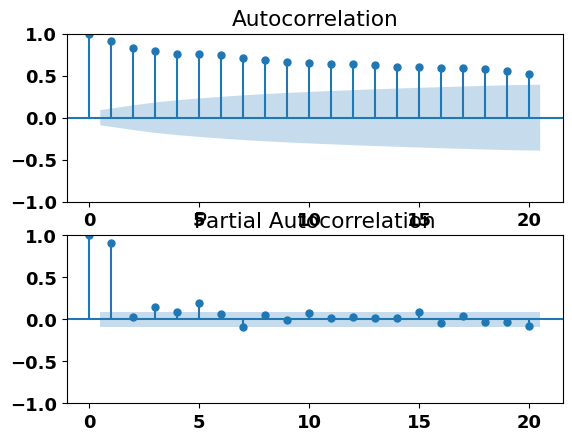

In [161]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2)
ax[0] = plot_acf(train, ax=ax[0], lags=20)
ax[1] = plot_pacf(train, ax=ax[1], lags=20)

In [157]:
# time_train
# x_train
# time_valid
# x_valid

In [163]:
from pmdarima.arima import auto_arima

model = auto_arima(x_train, start_p=1, start_q=1,
                   max_p=3, max_q=3, m=20,
                   start_P=0, seasonal=True,
                   d=1, D=1, trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True)
print(model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[20]             : AIC=inf, Time=11.86 sec
 ARIMA(0,1,0)(0,1,0)[20]             : AIC=4247.461, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[20]             : AIC=4102.355, Time=0.81 sec
 ARIMA(0,1,1)(0,1,1)[20]             : AIC=inf, Time=5.83 sec
 ARIMA(1,1,0)(0,1,0)[20]             : AIC=4242.982, Time=0.13 sec
 ARIMA(1,1,0)(2,1,0)[20]             : AIC=4032.757, Time=2.35 sec
 ARIMA(1,1,0)(2,1,1)[20]             : AIC=inf, Time=9.83 sec
 ARIMA(1,1,0)(1,1,1)[20]             : AIC=inf, Time=2.80 sec
 ARIMA(0,1,0)(2,1,0)[20]             : AIC=4033.050, Time=1.90 sec
 ARIMA(2,1,0)(2,1,0)[20]             : AIC=4020.645, Time=3.15 sec
 ARIMA(2,1,0)(1,1,0)[20]             : AIC=4092.482, Time=1.23 sec
 ARIMA(2,1,0)(2,1,1)[20]             : AIC=inf, Time=11.87 sec
 ARIMA(2,1,0)(1,1,1)[20]             : AIC=inf, Time=5.77 sec
 ARIMA(3,1,0)(2,1,0)[20]             : AIC=4014.618, Time=3.14 sec
 ARIMA(3,1,0)(1,1,0)[20]             : AIC=4084

In [164]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  473
Model:             SARIMAX(2, 1, 1)x(2, 1, [], 20)   Log Likelihood               -1992.036
Date:                             Fri, 12 Apr 2024   AIC                           3996.071
Time:                                     06:40:27   BIC                           4020.753
Sample:                                          0   HQIC                          4005.797
                                             - 473                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6691      0.065     10.351      0.000       0.542       0.796
ar.L2         -0.1242      0.055     -2.278      0.023      -0.231      -0.017
ma.L1         -0.8286      0.055    -15.150      0.000      -0.936      -0.721
ar.S.L20      -0.7344      0.043    -16.912      0.000      -0.820      -0.649
ar.S.L40      -0.4175      0.039    -10.586      0.000      -0.495      -0.340
sigma2       381.7613     20.079     19.013      0.000     342.408     421.114
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                69.68
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.85   Skew:                            -0.34
Prob(H) (two-sided):                  0.32   Kurtosis:                         4.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

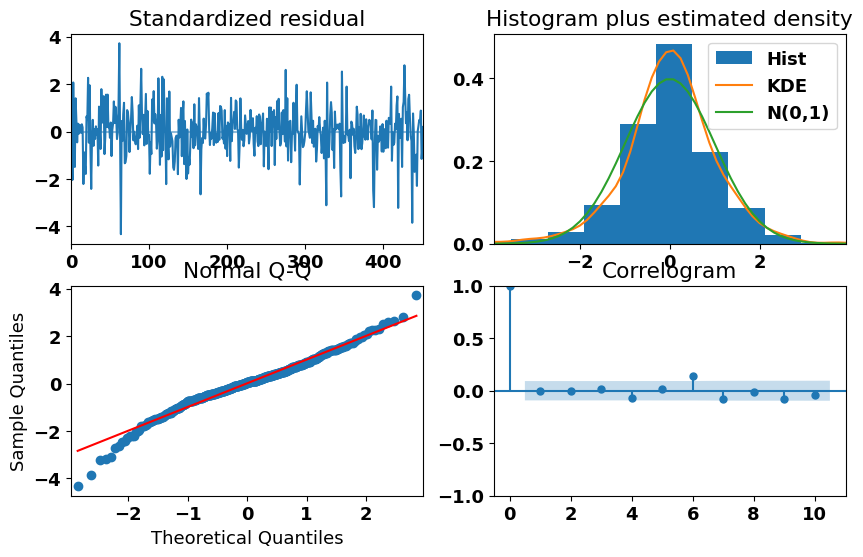

In [166]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=(10,6)
model.plot_diagnostics()
plt.show()

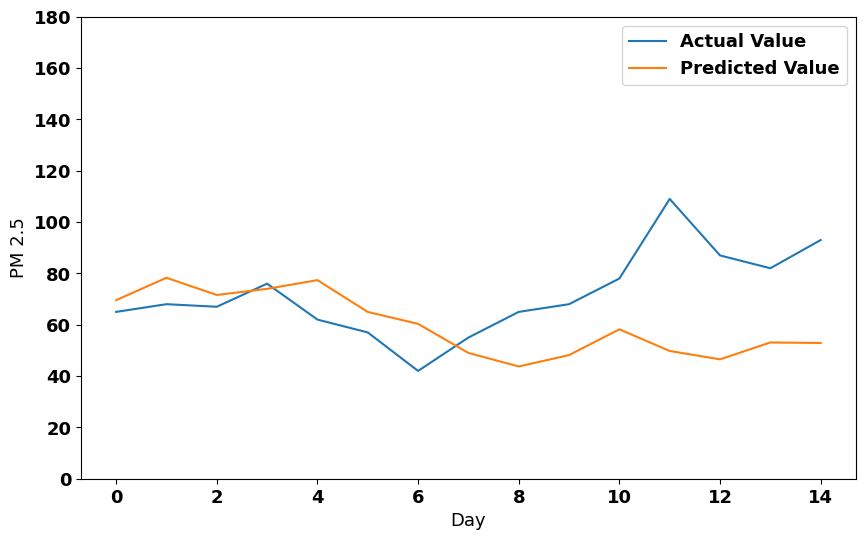

In [174]:
forecast = model.predict(n_periods=len(x_valid))

plt.plot(x_valid, label='Test')
plt.plot(forecast, label='Prediction')
plt.ylim([0,180])
plt.xlabel('Day')
plt.ylabel('PM 2.5')
plt.legend(['Actual Value', 'Predicted Value'])
plt.show()

In [175]:
from math import sqrt
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(x_valid,forecast)
print(mae)

19.918492809107622
